# Relocation Destination Personalization Machination Recommendation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

<div class="alert alert-block alert-warning">
<b>Notice</b> <br>
    Make sure your questionnaire Excel file is in the same folder as this Jupyter notebook, otherwise make sure the read_excel directory is correct.</div>

In [4]:
# import your quiz results
quiz = pd.read_excel("../data/external/user_responses/RDPM Questionnaire.xlsx", sheet_name="Upload")

#### Feel free to scroll through the code or click here on [Results](#Results) to skip to your results and some fancy visualizations.

Much of this code relies on 'FIPS' [(Federal Information Processing Standards)](https://www.nist.gov/itl/fips-general-information), which is a NIST [(National Institute of Standards and Technology)](https://www.nist.gov/) standard of identifying counties within the USA. For simplicity, we use FIPS as the unique indentifier whenever possible in this project.

In [5]:
# get county data and count data rows
github_url = "https://raw.githubusercontent.com/rabader/relocation-personalization/main/data/"

FIPS_d = pd.read_csv(github_url + "processed/FIPS_ref.csv").set_index('FIPS')
rel_d = pd.read_csv(github_url + "processed/Religion_dataset.csv").set_index('FIPS')
sd_d = pd.read_csv(github_url + "interim/School_2018_imputed.csv")
ter_d = pd.read_csv(github_url + "processed/Terrain_dataset.csv").set_index('FIPS')
wth_d = pd.read_csv(github_url + "processed/Weather_etc_State_dataset.csv")
acs_d = pd.read_csv(github_url + "interim/ACS_2020_imputed.csv").set_index('FIPS')
hth_d = pd.read_csv(github_url + "interim/health_imputed.csv").set_index('FIPS')
fbi_d = pd.read_csv(github_url + "interim/fbi_imputed.csv").set_index('FIPS')
pol_d = pd.read_csv(github_url + "processed/Politics.csv").set_index('FIPS')
tax_d = pd.read_csv(github_url + "processed/Taxes.csv")

print("FIPS: " + str(len(FIPS_d)), '\n', "Religion: " + str(len(rel_d)), '\n', "School District: " + str(len(sd_d)),
    '\n', "Terrain: " + str(len(ter_d)), '\n', "Weather: " + str(len(wth_d)), '\n', "Census: " + str(len(acs_d)),
      '\n', "Health: " + str(len(hth_d)), '\n', "Crime: " + str(len(fbi_d)), '\n', "Politics: " + str(len(pol_d)),
     '\n', "Taxes: " + str(len(tax_d)))

FIPS: 3153 
 Religion: 3149 
 School District: 18787 
 Terrain: 9356 
 Weather: 50 
 Census: 3221 
 Health: 25125 
 Crime: 17489 
 Politics: 18078 
 Taxes: 51


In [6]:
# remove Alaska, Puerto Rico, and DC
FIPS_d = FIPS_d[(FIPS_d['State']!='Alaska') & (FIPS_d['State']!='Puerto Rico') &
                (FIPS_d['State']!= 'District Of Columbia')]

In [7]:
# include only counties that are commonly included in all datasets
print("Starting county count: " + str(len(FIPS_d.index)))
FIPS_d = FIPS_d.filter(items = fbi_d.index.unique(), axis=0) # crime
FIPS_d = FIPS_d.filter(items = ter_d.index.unique(), axis=0) # terrain
FIPS_d = FIPS_d.filter(items = rel_d.index.unique(), axis=0) # religion
FIPS_d = FIPS_d.filter(items = hth_d.index.unique(), axis=0) # health
print("Final county count: " + str(len(FIPS_d.index)))

Starting county count: 3116
Final county count: 2891


In [8]:
# add 'Scores' column with 0 penalty points to each dataset to accumulate penalty points by topic
dfs = [FIPS_d, rel_d, sd_d, ter_d, wth_d, acs_d, hth_d, fbi_d, pol_d, tax_d]

for df in dfs:
    df['Scores'] = 0 # create empty Scores column for all data

In [9]:
# create empty importance list for all data
dfs_str = ['FIPS_d', 'rel_d', 'sd_d', 'ter_d', 'wth_d', 'acs_d', 'hth_d', 'fbi_d', 'pol_d', 'tax_d']

for df in dfs_str:
    exec(df+'_imp = []')

<div class="alert alert-block alert-info">
    <b>Function description: </b><i>grader</i><br>
The "grader" method below tests any question based on the 5-point scale of 1-5 which is matched with "Much less than average", "Less than average", "About average", "More than average", and "Much more than average" respectively.
<br><br>
It has three arguments:<br>
1) the current topic/dataframe being analyzed<br>
2) the row where the questionnaire response is recorded in the hidden sheet called "Upload"<br>
3) the column of the current dataframe that is being compared<br>
<br>
The importance score (imp_score) is recorded from the third column of the "Upload" sheet.
<br><br>
Depending on if the user response has "At least", "At most", or otherwise in the "<=>" column, the response is rated differently. score_series is a series result of finding the difference between the user answer of 1-5 versus each county's value of 1-5. If the user chose "At least", the user value (e.g. 5) is subtracted by each county's value (e.g. 2). The result (3 in this case) is larger than 0 (a max function is used to remove negatives) so the result remains. The result is squared (3**2=9) and then multiplied by the importance score of 0-10. For "At most", the positions in the subtraction is reversed. For "Equal to" or blank, the result is the absolute difference between values, squared, and multiplied by the importance score.<br><br>
The required arguments are:<br>
1) 'dataframe' (e.g. pol_d)<br>
2) the 'response row' number (e.g. 4) that is in the hidden "Upload" sheet in the Excel questionnaire that holds the questionnaire responses in a more computer readable format<br>
3) the column name within the dataframe that holds the 'actual' values for each county
</div>

In [10]:
def grader(df, response_row, actual):
    
    imp_score = quiz.iloc[response_row,3] # importance score of this question
    
    if quiz.iloc[response_row,1] == "At least":
        score_series = df[actual].apply(lambda x: max(quiz.iloc[response_row,2] - x, 0)**2 * imp_score)
    elif quiz.iloc[response_row,1] == "At most:":
        score_series = df[actual].apply(lambda x: max(x - quiz.iloc[response_row,2], 0)**2 * imp_score)
    else: 
        score_series = abs(quiz.iloc[response_row,2] - df[actual])**2 * imp_score
    
    return score_series, imp_score

<div class="alert alert-block alert-info">
    <b>Function description: </b><i>most_recent</i><br>
Some datasets have data from multiple years. Sometimes the year of the most recent data does not match throughout the dataset. The function below retrieves only the most recent year of information for each county for grading against the questionnaire.<br>
The required argument is:<br>
1) 'dataframe' (e.g. pol_d)
</div>

In [11]:
# create function that uses the most recent year in the dataset for questionnaire comparison
def most_recent(df):
    df_all = df.copy()
    df = df.reset_index()
    df_recent = df.copy()
    df_recent = df_recent.groupby(['FIPS'])['Year'].max() # get most recent data per county
    df_recent = df_recent.reset_index()
    df_recent = pd.DataFrame(df_recent, columns=['FIPS','Year']) # make df of each FIPS and most recent year
    df = pd.merge(df_recent, df, left_on=['FIPS','Year'], right_on=['FIPS','Year'], how='left') # filter df to match
    df = df.set_index('FIPS')
    return df_all, df

## Religion

In [12]:
# Rel) blanks in this dataset are equal to zero
rel_d = rel_d.fillna(0)

In [13]:
# Rel-1) I prefer the % of the population adhering to any religion to be:
score, imp_score = grader(rel_d, 47, 'All Religious Adherence Rate D') 
rel_d['Scores'] += score 
rel_d_imp.append(imp_score)

<div class="alert alert-block alert-info">
<b>Explanation:</b><br>
The question below (Rel-2) is one of a few based on a percentage instead of the 5-point scale like most of the other questions. In the 5-point scale questions, the largest possible difference between user and county values is four (e.g. 5-1=4). To normalize a percentage (100 point) scale, the difference is divided by 25. For example, if 0% of a religious group is found in a county, then (100-0)/25 = 4, which is the largest possible difference in the 5-point scale questions. The remaining value of 4 is also then squared and multiplied by the importance score.
</div>

In [14]:
# Rel-2) I prefer there to be a significant presence of this religious group:
if quiz.iloc[48,2] != 0: # if user gave an answer
    rel2_response = rel_d.loc[:,str(quiz.iloc[48,2])]
    rel_d['Scores'] += (((100 - rel2_response)/25)**2) * quiz.iloc[48,3]
rel_d_imp.append(quiz.iloc[48,3]) # imp_score

In [15]:
# add rel_d scores to combined FIPS_d score total
FIPS_d['Scores'] = FIPS_d['Scores'].add(rel_d['Scores'], fill_value=0)

## School District

In [16]:
# SD) first questions
sd_cats = ['SchoolDigger Number of Stars Elementary', 'SchoolDigger Number of Stars Middle', 
          'SchoolDigger Number of Stars High', 'Student/Teacher Ratio D', 'Number All Students D']

start_loc = 35 # start_loc is is the starting row for the questionnaire answer sheet
for sd_cat in sd_cats:
    score, imp_score = grader(sd_d, start_loc + sd_cats.index(sd_cat), sd_cat)
    sd_d['Scores'] += score
    sd_d_imp.append(imp_score)

In [17]:
# SD-6) For racial distribution, I prefer there to be AT LEAST this percentage of each race:
races = ['% Asian students', '% Black students', '% Hawaiian Native/Pacific Islander students', '% Hispanic students',
           '% American Indian/Alaska Native students', '% students with Two or More Races', '% White students']

for race in races:
    sd_d['Scores'] += sd_d[race].apply(lambda x: max(((quiz.iloc[races.index(race)+40,2] - x)/25)**2,0) * quiz.iloc[46,3])
sd_d_imp.append(imp_score)

<div class="alert alert-block alert-info">
<b>Explanation:</b><br>
There are often instances of multiple school districts being present in the same county. We decided to assign the score of the least penalized school district within each county to each county. Our logic is that if a user had an option of which school district to choose and cared enough to check school ratings, they would lean towards finding a home within the superior school district. The code assigns the least penalized school district to the county.
</div>

In [18]:
# SD) get lowest penalty score district for each county, reset series to dataframe, reset index
sd_d_grouped = sd_d.groupby(['County','State'])['Scores'].min().to_frame().reset_index() # get district with lowest penalty

<div class="alert alert-block alert-info">
<b>Explanation:</b><br>
This dataset is one of a few that do not have FIPS scores assigned as an index, so score had to be added to the the cumulative FIPS_d dataset through a merge instead of addition.
</div>

In [19]:
# SD) add grouped SD data to FIPS Scores through join
FIPS_d = FIPS_d.reset_index()
sd_d_scores = sd_d_grouped[['County','State','Scores']].rename({'Scores':'sd_Scores'}, axis='columns')
FIPS_d = pd.merge(FIPS_d, sd_d_scores, left_on=['County','State'], right_on=['County','State'], how='left')
FIPS_d['sd_Scores'] = FIPS_d['sd_Scores'].fillna(FIPS_d['sd_Scores'].mean()) # give mean penalty to non-matching districts
FIPS_d['Scores'] += FIPS_d['sd_Scores'] # add SD points to cumulative points
del FIPS_d['sd_Scores']
FIPS_d = FIPS_d.set_index('FIPS')

## Terrain

In [20]:
# test against only the most recent completed year but keep entirity for time series analysis
ter_d_all, ter_d = most_recent(ter_d)

In [21]:
# Ter) test against only the most recent completed year but keep entirity for time series analysis
ter_d_all = ter_d.copy()
ter_d = ter_d_all[ter_d['Year']==2011]

In [22]:
# Ter-1) For terrain, I prefer there to be AT LEAST this percentage of each terrain:
terrains = ['Big city', 'Farmland', 'Forests', 'Houses with lots of land', 'Open fields', 'Open water', 
            'Perennial ice/snow', 'Rock/Sand/Clay', 'Suburbia', 'Wetlands']

for terrain in terrains:
    ter_d['Scores'] += ter_d[terrain].apply(
        lambda x: max(((quiz.iloc[terrains.index(terrain)+14,2] - x)/25)**2,0) * quiz.iloc[terrains.index(terrain)+14,3])
ter_d_imp.append(quiz.iloc[terrains.index(terrain)+14,3])

In [23]:
# Ter) add ter_d scores to FIPS_d score total
FIPS_d['Scores'] = FIPS_d['Scores'].add(ter_d['Scores'], fill_value=0)

## State Level Weather

In [24]:
# Wth) first questions
wth_cats = ['Winter Avg temp (F) D', 'Summer Avg temp (F) D', 'Avg Yearly Rainfall (in) D', 'Avg Yearly Snowfall (in) D',
          'Avg Hours Sunshine Daily D', 'Avg Clear Days D', 'Avg Days with Snow D']

start_loc = 28
for wth_cat in wth_cats:
    score, imp_score = grader(wth_d, start_loc + wth_cats.index(wth_cat), wth_cat)
    wth_d['Scores'] += score
    wth_d_imp.append(imp_score)

In [25]:
# Wth) add state Wth data to FIPS Scores through join
FIPS_d = FIPS_d.reset_index()
wth_d_scores = wth_d[['State','Scores']].rename({'Scores':'wth_Scores'}, axis='columns')
FIPS_d = pd.merge(FIPS_d, wth_d_scores, left_on='State', right_on='State', how='left')
FIPS_d['Scores'] += FIPS_d['wth_Scores']
del FIPS_d['wth_Scores']
FIPS_d = FIPS_d.set_index('FIPS')

## Census

In [26]:
# ACS) first questions
acs_cats = ['% Pop Density D', '% Children Under 10 D', '% Children 10 and Older D', '% Couples that are Same-Sex D',
           '% Population Over 25 with at Least a Bachelor Degree D', 
           '% Civilian Population 18 Years and Over that is a Veteran D',
           '% Foreign Born D']

start_loc = 0
for acs_cat in acs_cats:
    score, imp_score = grader(acs_d, start_loc + acs_cats.index(acs_cat), acs_cat)
    acs_d['Scores'] += score
    acs_d_imp.append(imp_score)

In [27]:
# ACS-8) For racial distribution, I prefer the percentage of each race to be AT LEAST:
races = ['% Asian', '% Black', '% Hawaiian or Pacific Islander', '% Hispanic', '% Native American', 
         '% Two or More Races', '% White', '% Other Race']

for race in races:
    acs_d['Scores'] += acs_d[race].apply(lambda x: max(((quiz.iloc[races.index(race)+7,2] - x)/25)**2,0) * quiz.iloc[14,3])
acs_d_imp.append(quiz.iloc[14,3])

In [28]:
# ACS) last questions
acs_cats = ['Median Household Income D', 'Median Gross Rent D', 'Average Commute to Work D']

start_loc = 15
for acs_cat in acs_cats:
    score, imp_score = grader(acs_d, start_loc + acs_cats.index(acs_cat), acs_cat)
    acs_d['Scores'] += score
    acs_d_imp.append(imp_score)

In [29]:
# ACS) add acs scores to FIPS_d score total
FIPS_d['Scores'] = FIPS_d['Scores'].add(acs_d['Scores'], fill_value=0)

## Health

In [30]:
# test against only the most recent completed year but keep entirity for time series analysis
hth_d_all, hth_d = most_recent(hth_d)

In [31]:
# Hth) all questions
hth_cats = ['Primary Care Physicians Per 100,000 Population D',
'Mental Health Providers Per 100,000 Population D',
'Dentists Per 100,000 Population D',
'Percent Adults With Limited Access To Doctor Due To Costs D',
'Percent Persons With Limited Access To Healthy Foods D',
'Percent Physically Inactive Persons D',
'Percent Obese Persons Adults D',
'Percent Adults That Report Fair Or Poor Health D',
'Percent Current Adult Smokers D',
'Percent Drinking Adults D',
'STI Rate Per 100,000 Population D',
'Child Mortality Rate Per 100,000 Population D',
'Teen Births Rate Per 1,000 Population D',
'Infant Mortality Rate Per 1,000 Live Births D',
'Percent Low Birthweight Births (<2.5Kg) D']

start_loc = 49
for hth_cat in hth_cats:
    score, imp_score = grader(hth_d, start_loc + hth_cats.index(hth_cat), hth_cat)
    hth_d['Scores'] += score
    hth_d_imp.append(imp_score)

In [32]:
# Hth) add hth scores to FIPS_d score total
FIPS_d['Scores'] = FIPS_d['Scores'].add(hth_d['Scores'], fill_value=0)

## Crime

In [33]:
# test against only the most recent completed year but keep entirity for time series analysis
fbi_d_all, fbi_d = most_recent(fbi_d)

In [34]:
# FBI) all questions
fbi_cats = ['Violent Crimes Rate D','Property Crimes Rate D']

start_loc = 64
for fbi_cat in fbi_cats:
    score, imp_score = grader(fbi_d, start_loc + fbi_cats.index(fbi_cat), fbi_cat)
    fbi_d['Scores'] += score
    fbi_d_imp.append(imp_score)

In [35]:
# FBI) add fbi_d scores to FIPS_d score total
FIPS_d['Scores'] = FIPS_d['Scores'].add(fbi_d['Scores'], fill_value=0)

## Politics

In [36]:
# Pol) blanks in this dataset are equal to zero
pol_d = pol_d.fillna(0)

In [37]:
# Pol) test against only the most recent completed year but keep entirity for time series analysis
pol_d_all, pol_d = most_recent(pol_d)

In [38]:
# Pol) I prefer there to be a significant presence of this political group:
if quiz.iloc[66,2] != 0:
    pol_response = pol_d.loc[:,str(quiz.iloc[66,2])]
    pol_d['Scores'] += (((100 - pol_response)/25)**2) * quiz.iloc[66,3]
pol_d_imp.append(quiz.iloc[66,3])

In [39]:
# Pol) add pol_d scores to FIPS_d score total
FIPS_d['Scores'] = FIPS_d['Scores'].add(pol_d['Scores'], fill_value=0)

## State Taxes

In [40]:
# Tax) all questions
tax_cats = ['State and Mean Local Sales Tax D','Income Tax (Lowest Bracket) D',
            'Income Tax (Highest Bracket) D', 'Median Property Tax D']

start_loc = 67
for tax_cat in tax_cats:
    score, imp_score = grader(tax_d, start_loc + tax_cats.index(tax_cat), tax_cat)
    tax_d['Scores'] += score
    tax_d_imp.append(imp_score)

In [41]:
# Tax) add state tax data to FIPS Scores through join
tax_d_scores = tax_d[['State','Scores']].rename({'Scores':'tax_Scores'}, axis='columns')

FIPS_d = FIPS_d.reset_index()
FIPS_d = pd.merge(FIPS_d, tax_d_scores, left_on=['State'], right_on=['State'], how='left')
FIPS_d['Scores'] += FIPS_d['tax_Scores']
del FIPS_d['tax_Scores']
FIPS_d = FIPS_d.set_index('FIPS')

In [42]:
# sort values and remove unneeded rows
FIPS_d.sort_values(by='Scores', inplace=True)
FIPS_d = FIPS_d.round({'Scores':2})

### Visualization Preparation Code

In [43]:
# radar chart of category importance
categories = ['Census', 'Terrain', 'Weather', 'School District', 'Religion', 'Health', 'Crime', 'Politics', 'Taxes']
importance_means = [np.mean(acs_d_imp), np.mean(ter_d_imp), np.mean(wth_d_imp), np.mean(sd_d_imp), 
                    np.mean(rel_d_imp), np.mean(hth_d_imp), np.mean(fbi_d_imp), np.mean(pol_d_imp),
                    np.mean(tax_d_imp)]

imp_viz_df = pd.DataFrame(dict(Category = categories, Mean_Importance = importance_means))

imp_viz = px.line_polar(imp_viz_df, r='Mean_Importance', theta='Category', line_close=True,
                       title="Mean Question Importance by Category")
imp_viz = imp_viz.update_traces(fill='toself')

/opt/miniconda3/envs/siads699/lib/python3.10/site-packages/plotly/express/_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])


In [44]:
# desired features for table comparison
acs_features = ['County', 'State', 'Total Population', '% Children Under 10', '% Children 10 and Older', 
                '% Couples that are Same-Sex', '% Population Over 25 with at Least a Bachelor Degree',
               'Median Household Income (In 2020 Inflation Adjusted Dollars)', 'House Median Value',
               'Median Gross Rent', '% Families with Income Below Poverty Level', 'Average Commute to Work (In Min)',
               '% Civilian Population 18 Years and Over that is a Veteran']
sd_features = ['County','State','Number of All students','Total Student membership/Full-Time-Equvalent teachers',
               'SchoolDigger Number of Stars Elementary','SchoolDigger Number of Stars Middle',
               'SchoolDigger Number of Stars High']
fbi_features = ['County','State','Violent Crimes Rate','Property Crimes Rate']
fbi_features_year = ['County','State','Year','Violent Crimes Rate','Property Crimes Rate']
pol_features = ['County','State','Democrat','Libertarian','Green','Republican','Other']
ter_features_year = ['County','State','Year','Farmland','Houses with lots of land','Suburbia','Big city','Forests',
                     'Open fields','Wetlands','Open water','Rock/Sand/Clay','Perennial ice/snow']
tax_features_low = ['State and Mean Local Sales Tax','Income Tax (Lowest Bracket)','Median Property Tax']
tax_features_high = ['State and Mean Local Sales Tax','Income Tax (Highest Bracket)','Median Property Tax']
wth_features = ['Winter Avg temp (F)','Summer Avg temp (F)','Avg Yearly Rainfall (in)','Yearly snowfall (in)',
                'Hours Sunshine Daily','Clear Days','Days with Snow']
hth_features_year = ['County','State','Year','Primary Care Physicians (PCP) Rate Per 100,000 Population',
                'Mental Health Providers (MHP) Rate Per 100,000 Population','Dentists Rate Per 100,000 Population',
                'Percent Adults With Limited Access To Doctor Due To Costs',
                'Percent Persons With Limited Access To Healthy Foods','Percent Physically Inactive Persons (20 Years And Over)',
                'Percent Obese Persons (20 Years And Over)','Percent Adults That Report Fair Or Poor Health (Persons 18 Years And Over)',
                'Percent Current Smokers (Persons 18 Years And Over)','Percent Drinking Adults (Persons 18 Years And Over)',
                     'STI Rate Per 100,000 Population',
                'Child Mortality Rate Per 100,000 Population','Teen Births Rate Per 1,000 Population (Females 15 To 19 Years)',
                'Infant Mortality Rate Per 1,000 Live Births','Percent Low Birthweight Births (<2.5Kg)']

<div class="alert alert-block alert-info">
    <b>Function description: </b><i>top_x_comp_nat</i><br>
This function creates a new dataframe that holds only selected columns that are the most useful for comparison between counties or for visualizations.<br><br>
The required arguments are:<br>
1) 'dataframe' (e.g. sd_d)<br>
2) the matching 'dataframe features' as seen in the cell above (e.g. sd_features if using sd_d)<br>
3) the 'number of top counties to compare' (e.g. 3)
</d>

In [45]:
def top_x_comp_nat(df, df_features, x):
    # get national means of df
    if df.columns[1] == "School District Name": # if school district df
        top_x_FIPS_d = FIPS_d[:x] # get County and State for top x for filtering
        df_means = pd.DataFrame(round(df.iloc[:,5:].mean(),1)).T # get national mean values
        df_means['County'] = 'National Mean'
        df_means['State'] = 'National Mean'
        # filter sd_d to show only top x county/state values
        df_top_x_all = pd.merge(top_x_FIPS_d, df, left_on=['State','County'], right_on=['State','County'], how='left')
        df_top_x_all = pd.concat([df_means, df_top_x_all], join="inner") # add national mean values to df
    else: # FBI, Terrain, Religion, Health
        top_x_FIPS = FIPS_d.reset_index()[:x]['FIPS'] # get FIPS of top x counties
        df_top_x = df.loc[top_x_FIPS] # df scores of top x counties
        if df.columns[3] == 'FIPS_Year': # if FBI
            df_means = pd.DataFrame(round(df.iloc[:,5:].mean(),1)).T # get national mean values
        else:
            df_means = pd.DataFrame(round(df.iloc[:,2:].mean(),1)).T # get national mean values
        df_means['County'] = 'National Mean'
        df_means['State'] = 'National Mean'
        df_top_x_all = pd.concat([df_means, df_top_x], join="inner") # add national mean values to df
    df_top_x_comp_nat = df_top_x_all[df_features] # keep only featured columns
    # change column order to put County and State first
    state = df_top_x_comp_nat.pop('State')
    df_top_x_comp_nat.insert(0, 'State', state)
    county = df_top_x_comp_nat.pop('County')
    df_top_x_comp_nat.insert(0, 'County', county)
    df_top_x_comp_nat = df_top_x_comp_nat.T # transpose dataframe
    df_top_x_comp_nat.columns = df_top_x_comp_nat.iloc[0] # change column names to counties
    df_top_x_comp_nat = df_top_x_comp_nat.iloc[1:,:] # remove county name row
    return df_top_x_comp_nat

<div class="alert alert-block alert-info">
    <b>Function description: </b><i>get_top_x_year</i><br>
This function retrieves only the top x counties of only the most recent year that county has data available.<br><br>
The required arguments are:<br>
1) 'dataframe' (e.g. pol_d)<br>
2) the 'number of top counties to compare' (e.g. 3)
</div>

In [46]:
def get_top_x_year(df, x):
    top_x_FIPS = FIPS_d.reset_index()[:x]['FIPS'] # get FIPS of top x counties
    top_x_df = df.loc[top_x_FIPS] # get df of those counties
    return top_x_df.loc[:,top_x_df.columns != 'Scores'] # return all data except 'Scores' column

<div class="alert alert-block alert-info">
    <b>Function description: </b><i>pol_over_time</i><br>
This function retrieves and rearranges Politics data to help fit it in the Presidential politics over time of top four counties visual.<br><br>
The required arguments are:<br>
1) 'dataframe' (pol_top_x_all)<br>
2) the number rank of county to process (e.g. 0 for the top ranked county)<br><br>
This function should be used in conjuction with the 'get_top_x_year' function as the dataframe argument as seen below.
</div>

In [47]:
def pol_over_time(df,x):
    FIPS_top_4 = list(df.index.unique()) # get list of sorted county FIPS
    county_x = df.loc[FIPS_top_4[x]] # get data for top x county
    county_x_year = sorted(list(county_x['Year'])) # get years with data
    county_x_year = list(map(str,county_x_year)) # change years to string
    county_name = county_x['County'].iloc[0] # get county name
    y1 = county_x.loc[:,'Democrat']
    y2 = county_x.loc[:,'Libertarian']
    y3 = county_x.loc[:,'Green']
    y4 = county_x.loc[:,'Republican']
    y5 = county_x.loc[:,'Other']
    return county_x_year, county_name, y1, y2, y3, y4, y5

In [48]:
# Presidential politics over time of top four counties: data collection
pol_top_x_all = get_top_x_year(pol_d_all,4) # get all years of top 4 counties
parties = ['Democrat','Libertarian','Green','Republican','Other']

county_0_years, county_0_name, y1_0, y2_0, y3_0, y4_0, y5_0 = pol_over_time(pol_top_x_all,0)
county_1_years, county_1_name, y1_1, y2_1, y3_1, y4_1, y5_1 = pol_over_time(pol_top_x_all,1)
county_2_years, county_2_name, y1_2, y2_2, y3_2, y4_2, y5_2 = pol_over_time(pol_top_x_all,2)
county_3_years, county_3_name, y1_3, y2_3, y3_3, y4_3, y5_3 = pol_over_time(pol_top_x_all,3)

In [49]:
# feature prep for Census visualizations
household_income = ['% Households Income: Less than $10,000','% Households Income: $10,000 to $14,999',
                    '% Households Income: $15,000 to $19,999','% Households Income: $20,000 to $24,999',
                    '% Households Income: $25,000 to $29,999','% Households Income: $30,000 to $34,999',
                    '% Households Income: $35,000 to $39,999','% Households Income: $40,000 to $44,999',
                    '% Households Income: $45,000 to $49,999','% Households Income: $50,000 to $59,999',
                    '% Households Income: $60,000 to $74,999','% Households Income: $75,000 to $99,999',
                    '% Households Income: $100,000 to $124,999','% Households Income: $125,000 to $149,999',
                    '% Households Income: $150,000 to $199,999','% Households Income: $200,000 or More']
foreign_born = ['% Foreign-Born Population: Africa','% Foreign-Born Population: Asia',
                '% Foreign-Born Population: Europe','% Foreign-Born Population: Latin America',
                '% Foreign-Born Population: Northern America','% Foreign-Born Population: Oceania']

acs_top_5 = acs_d.loc[FIPS_d.reset_index()[:5]['FIPS']]
# remove repetitive starting words for legend labels
household_income_legend = [[x[21:] for x in household_income]][0]
foreign_born_legend = [[x[27:] for x in foreign_born]][0]

acs_topx_all = get_top_x_year(acs_d, 5) # get most recent year's data for top x census counties

<a id="Results"></a>

## Your Top Ten Counties Results

In [50]:
FIPS_d.head(10)

,County,State,Scores
FIPS,,,
1001,Autauga County,Alabama,0.0
39117,Morrow County,Ohio,0.0
39119,Muskingum County,Ohio,0.0
39121,Noble County,Ohio,0.0
39123,Ottawa County,Ohio,0.0
39125,Paulding County,Ohio,0.0
39127,Perry County,Ohio,0.0
39129,Pickaway County,Ohio,0.0
39131,Pike County,Ohio,0.0


#### Radar plot of the mean importance score you gave to each category

In [51]:
# show radar plot
imp_viz.show()

---

<div class="alert alert-block alert-warning">
    <b>How to use the <i>top_x_comp_nat</i> functions:</b> <br>
This function displays a table that compares selected columns between your top county results.<br>
    You should <b>only change the number at the end</b> to explore more or fewer counties within the table.
</div>

#### Comparison of populations, income, housing, and commute across top counties

In [52]:
top_x_comp_nat(acs_d, acs_features, 5)

County,National Mean,Autauga County,Morrow County,Muskingum County,Noble County,Ottawa County
State,National Mean,Alabama,Ohio,Ohio,Ohio,Ohio
Total Population,102398.3,55639.0,35148.0,86033.0,14410.0,40557.0
% Children Under 10,11.7,13.0,10.0,12.0,11.0,9.0
% Children 10 and Older,10.3,11.1,12.1,10.3,7.7,9.8
% Couples that are Same-Sex,1.0,0.8,2.8,0.9,1.6,0.3
% Population Over 25 with at Least a Bachelor Degree,22.6,28.0,15.0,17.0,11.0,24.0
Median Household Income (In 2020 Inflation Adjusted Dollars),54167.5,57982.0,61769.0,48350.0,50070.0,59306.0
House Median Value,159679.2,161200.0,154900.0,126400.0,106100.0,154500.0
Median Gross Rent,782.8,1011.0,773.0,702.0,623.0,752.0
% Families with Income Below Poverty Level,11.2,12.7,5.9,11.7,10.0,5.4


#### Comparison of household income groups across top counties

In [53]:
# percentage of households within each household income group by county prep
acs_topx_all.set_index('County', inplace=True)

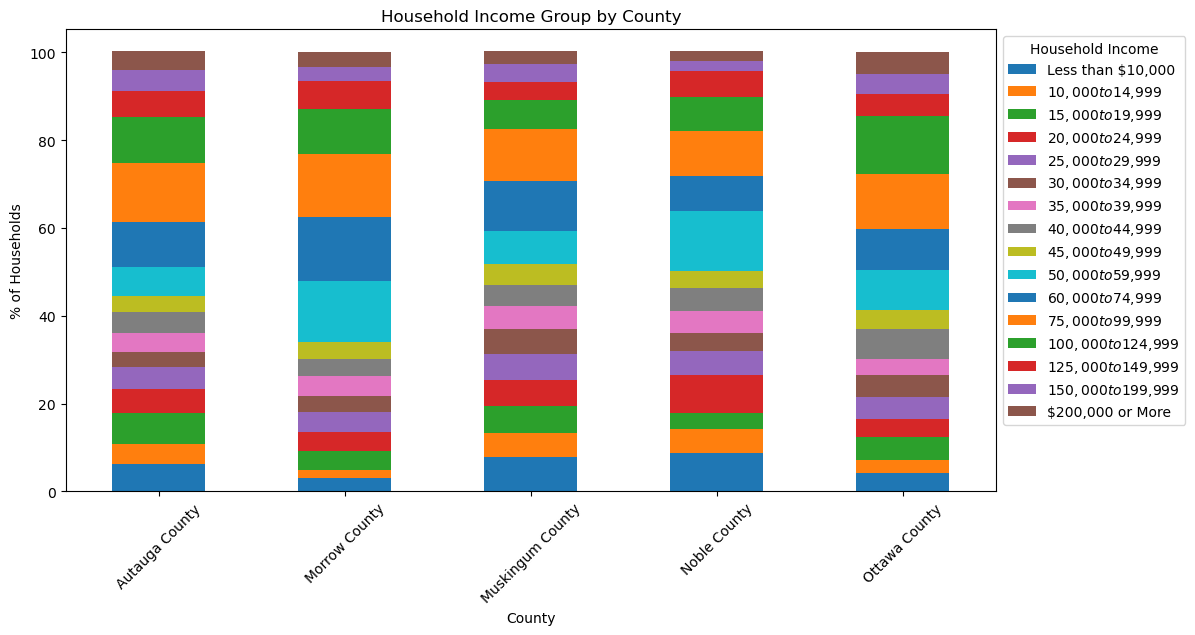

In [54]:
# create visualization for percentage of households
acs_topx_all[household_income].plot(kind='bar', stacked=True, figsize=(12,6))
plt.legend(bbox_to_anchor=(1,1), title="Household Income", labels=household_income_legend)
plt.title("Household Income Group by County")
plt.ylabel('% of Households')
plt.xticks(rotation=45)
plt.show()

#### Comparison of foreign-born populations by continent across top counties

In [55]:
acs_topx_all[foreign_born]

,% Foreign-Born Population: Africa,% Foreign-Born Population: Asia,% Foreign-Born Population: Europe,% Foreign-Born Population: Latin America,% Foreign-Born Population: Northern America,% Foreign-Born Population: Oceania
County,,,,,,
Autauga County,0.00,0.00,0.00,0.00,0.00,0
Morrow County,0.03,0.45,0.54,0.06,0.09,0
Muskingum County,0.06,0.44,0.16,0.07,0.09,0
Noble County,0.08,0.00,0.06,0.42,0.00,0
Ottawa County,0.01,0.32,0.43,0.40,0.10,0


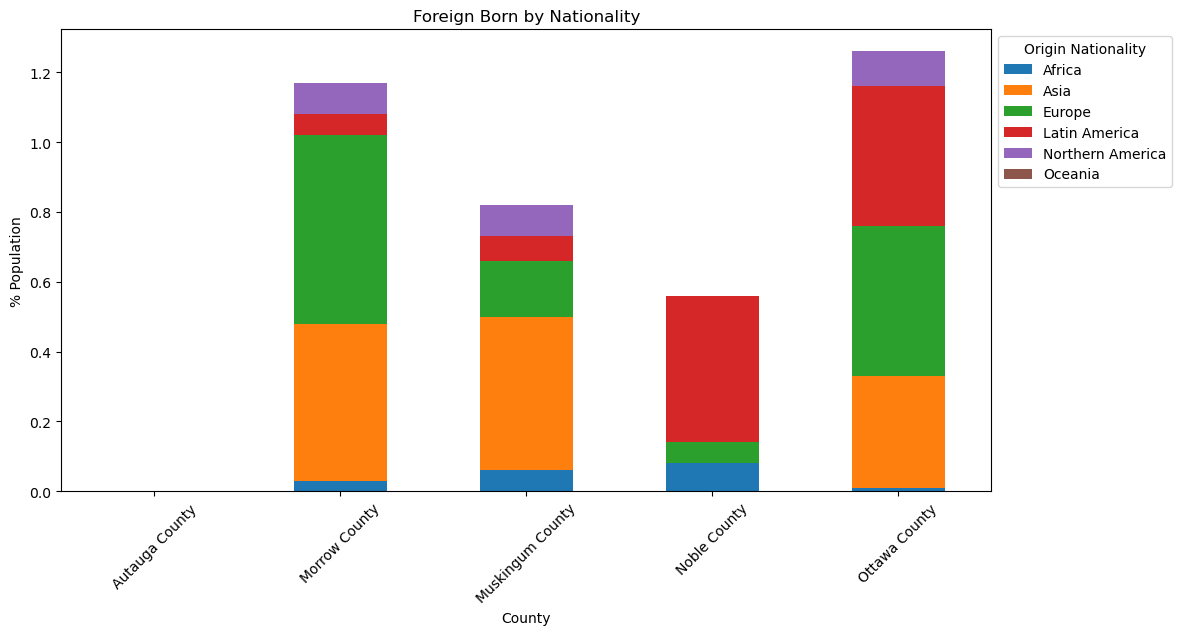

In [56]:
acs_topx_all[foreign_born].plot(kind='bar', stacked=True, figsize=(12,6))
plt.legend(bbox_to_anchor=(1,1), title="Origin Nationality", labels=foreign_born_legend)
plt.title("Foreign Born by Nationality")
plt.xlabel('County')
plt.ylabel('% Population')
plt.xticks(rotation=45)
plt.show()

#### Comparison of schools and ratings within your top school districts

In [57]:
top_x_comp_nat(sd_d, sd_features, 1)

County,National Mean,Autauga County
State,National Mean,Alabama
Number of All students,3145.2,9247.0
Total Student membership/Full-Time-Equvalent teachers,15.0,18.483333
SchoolDigger Number of Stars Elementary,2.6,3.0
SchoolDigger Number of Stars Middle,2.7,3.0
SchoolDigger Number of Stars High,2.7,3.0


#### Comparison of crime rates between counties

In [58]:
top_x_comp_nat(fbi_d, fbi_features, 5)

County,National Mean,Autauga County,Morrow County,Muskingum County,Noble County,Ottawa County
State,National Mean,Alabama,Ohio,Ohio,Ohio,Ohio
Violent Crimes Rate,109.0,91.724969,22.808918,68.61183,34.664448,9.760621
Property Crimes Rate,568.3,669.052715,333.58043,1050.11,249.584027,529.5137


In [59]:
# get data for all years of top x counties
fbi_top_x_all = get_top_x_year(fbi_d_all,5)[fbi_features_year].reset_index()

# calculate national means by year
fbi_d_grouped = fbi_d.reset_index()
fbi_d_grouped_v = fbi_d_grouped.groupby(['Year'])['Violent Crimes Rate'].mean().reset_index()
fbi_d_grouped_v['County'] = "National Mean"
fbi_d_grouped_v['State'] = "National Mean"
fbi_d_grouped_p = fbi_d_grouped.groupby(['Year'])['Property Crimes Rate'].mean().reset_index()
fbi_d_grouped_p['County'] = "National Mean"
fbi_d_grouped_p['State'] = "National Mean"

# add national means to top x table
fbi_top_x_comp_v = pd.concat([fbi_d_grouped_v, fbi_top_x_all],  join='inner', ignore_index=True)
fbi_top_x_comp_p = pd.concat([fbi_d_grouped_p, fbi_top_x_all],  join='inner', ignore_index=True)

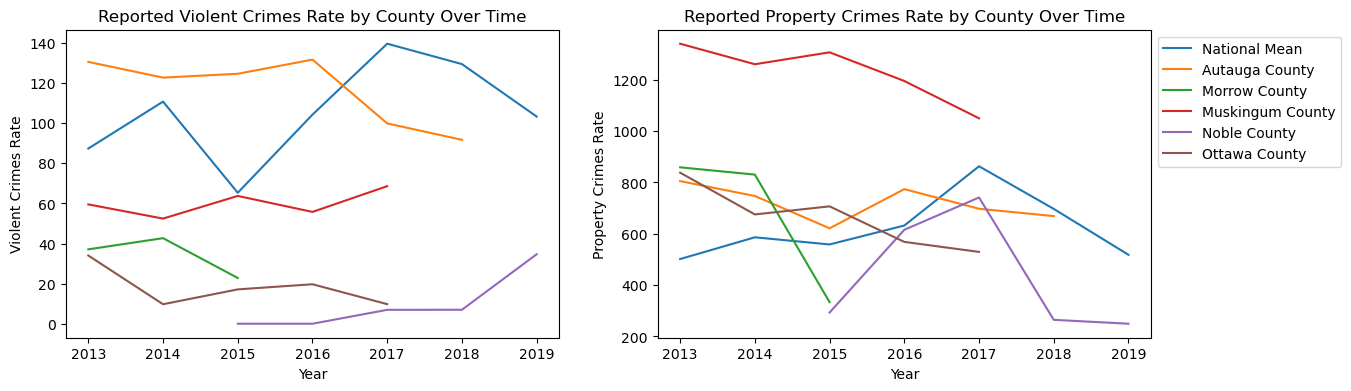

In [60]:
# create crime rate visualization
fig, axes = plt.subplots(1,2, figsize=(14,4), sharey=False)
sns.lineplot(data=fbi_top_x_comp_v, x='Year', y='Violent Crimes Rate', hue='County', ax=axes[0], legend=False).set(
         title="Reported Violent Crimes Rate by County Over Time")
sns.lineplot(data=fbi_top_x_comp_p, x='Year', y='Property Crimes Rate', hue='County', ax=axes[1]).set(
         title="Reported Property Crimes Rate by County Over Time")
plt.legend(bbox_to_anchor=(1,1));

#### Comparison of terrain type across top counties

In [61]:
ter_top_x_year = get_top_x_year(ter_d, 5)[ter_features_year]
ter_top_x_year

,County,State,Year,Farmland,Houses with lots of land,Suburbia,Big city,Forests,Open fields,Wetlands,Open water,Rock/Sand/Clay,Perennial ice/snow
FIPS,,,,,,,,,,,,,
1001,Autauga County,Alabama,2011,18.245288,5.425147,0.426098,0.113898,48.968160,19.409224,5.624540,1.520637,0.267008,0.0
39117,Morrow County,Ohio,2011,65.942136,6.885403,0.258046,0.062037,25.497212,0.538619,0.384082,0.429479,0.002987,0.0
39119,Muskingum County,Ohio,2011,29.879816,9.013120,0.721196,0.292787,54.491474,3.591050,0.200616,1.432473,0.377467,0.0
39121,Noble County,Ohio,2011,18.130493,7.496631,0.169037,0.031952,68.078485,4.108249,0.059180,1.373339,0.552634,0.0
39123,Ottawa County,Ohio,2011,60.556064,12.468848,2.031504,0.746459,3.646739,2.369674,12.151872,4.581317,1.447524,0.0


In [62]:
# terrain type visualization prep
ter_top_x_year.set_index('County', inplace=True)
ter_top_x_year = ter_top_x_year.loc[:,ter_top_x_year.columns != 'Year']

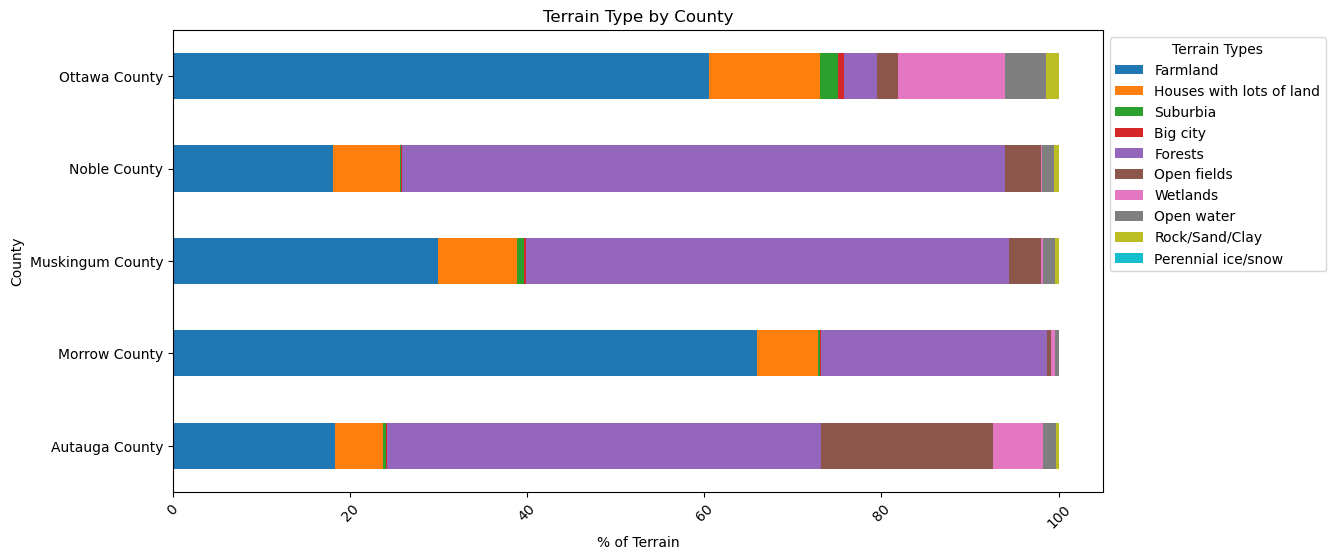

In [63]:
# create visualization for terrain comparison
ter_top_x_year.plot(kind='barh', stacked=True, figsize=(12,6))
plt.legend(bbox_to_anchor=(1,1), title="Terrain Types")
plt.title("Terrain Type by County")
plt.xlabel('% of Terrain')
plt.xticks(rotation=45)
plt.show()

#### Comparison of tax rates by state for top 10 counties

In [64]:
# visualization prep
top_states = FIPS_d.head()['State']
tax_vis_d = tax_d[tax_d['State'].isin(top_states)].set_index('State')
tax_vis_d_low = pd.DataFrame(tax_vis_d, columns=tax_features_low)
tax_vis_d_high = pd.DataFrame(tax_vis_d, columns=tax_features_high)

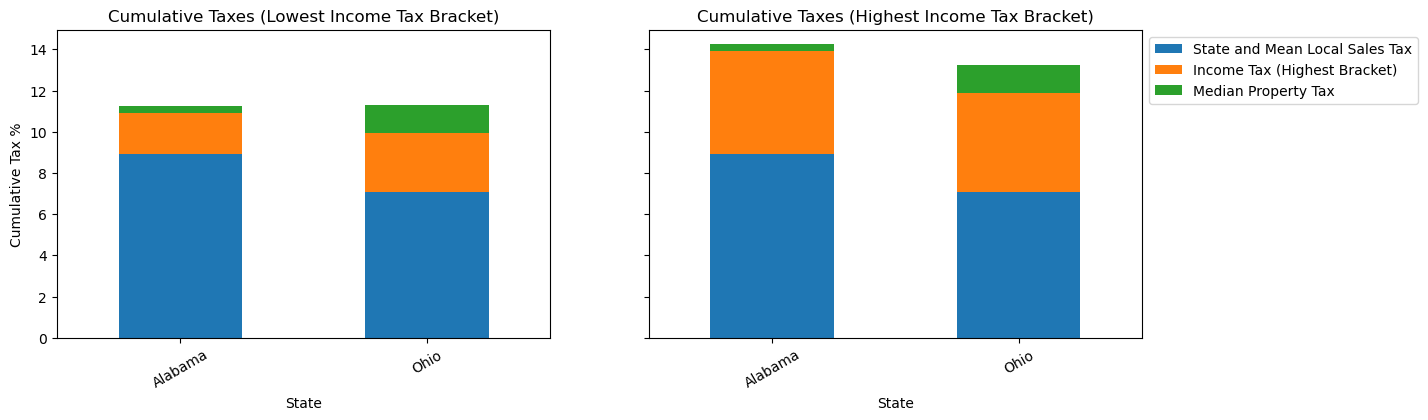

In [65]:
# create tax rate visualization
fig, axes = plt.subplots(1,2, figsize=(14,4), sharey=True)
tax_vis_d_low.plot(kind='bar', stacked=True, ax=axes[0], legend=False).set(
         title="Cumulative Taxes (Lowest Income Tax Bracket)")
tax_vis_d_high.plot(kind='bar', stacked=True, ax=axes[1]).set(
         title="Cumulative Taxes (Highest Income Tax Bracket)")
plt.legend(bbox_to_anchor=(1,1))
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=30)
    plt.ylabel('Cumulative Tax %')
plt.show();

#### Comparison of weather by state of top counties

In [66]:
wth_top_d = wth_d[wth_d['State'].isin(top_states)].set_index('State')
wth_top_d = pd.DataFrame(wth_top_d, columns=wth_features)
wth_top_d

,Winter Avg temp (F),Summer Avg temp (F),Avg Yearly Rainfall (in),Yearly snowfall (in),Hours Sunshine Daily,Clear Days,Days with Snow
State,,,,,,,
Alabama,46.5,78.6,58.3,1.6,7.2,99,0.8
Ohio,29.5,70.9,39.1,27.5,6.0,72,30.4


#### Comparison of Presidential votes by party

In [67]:
top_x_comp_nat(pol_d, pol_features, 4)

/var/folders/c4/44txy79x4x95gzrg3pt9mxs00000gn/T/ipykernel_54401/565081932.py:17: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



County,National Mean,Autauga County,Morrow County,Muskingum County,Noble County
State,National Mean,Alabama,Ohio,Ohio,Ohio
Democrat,33.1,27.02,21.93,29.58,18.45
Libertarian,0.9,0.0,1.39,1.13,0.39
Green,0.1,0.0,0.0,0.0,0.0
Republican,64.4,71.44,76.27,68.87,80.96
Other,1.5,1.54,0.41,0.42,0.2


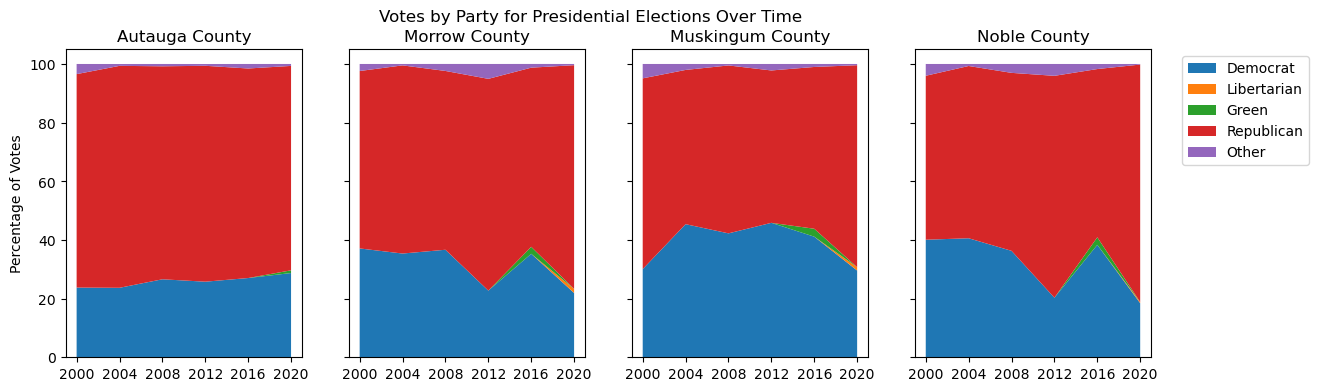

In [68]:
# presidential politics over time of top four counties: visual
fig, axes = plt.subplots(1,4, figsize=(14,4), sharey=True)
fig.suptitle('Votes by Party for Presidential Elections Over Time')
axes[0].stackplot(county_0_years, y1_0, y2_0, y3_0, y4_0, y5_0, labels=parties)
axes[0].set_title(county_0_name)
axes[1].stackplot(county_1_years, y1_1, y2_1, y3_1, y4_1, y5_1, labels=parties)
axes[1].set_title(county_1_name)
axes[2].stackplot(county_2_years, y1_2, y2_2, y3_2, y4_2, y5_2, labels=parties)
axes[2].set_title(county_2_name)
axes[3].stackplot(county_3_years, y1_3, y2_3, y3_3, y4_3, y5_3, labels=parties)
axes[3].set_title(county_3_name)
axes[0].set_ylabel('Percentage of Votes')
plt.legend(bbox_to_anchor=(1.7,1))
plt.show();

#### Comparison of health statistics of top counties

In [69]:
get_top_x_year(hth_d, 5)[hth_features_year]

,County,State,Year,"Primary Care Physicians (PCP) Rate Per 100,000 Population","Mental Health Providers (MHP) Rate Per 100,000 Population","Dentists Rate Per 100,000 Population",Percent Adults With Limited Access To Doctor Due To Costs,Percent Persons With Limited Access To Healthy Foods,Percent Physically Inactive Persons (20 Years And Over),Percent Obese Persons (20 Years And Over),Percent Adults That Report Fair Or Poor Health (Persons 18 Years And Over),Percent Current Smokers (Persons 18 Years And Over),Percent Drinking Adults (Persons 18 Years And Over),"STI Rate Per 100,000 Population","Child Mortality Rate Per 100,000 Population","Teen Births Rate Per 1,000 Population (Females 15 To 19 Years)","Infant Mortality Rate Per 1,000 Live Births",Percent Low Birthweight Births (<2.5Kg)
FIPS,,,,,,,,,,,,,,,,,,
1001,Autauga County,Alabama,2020,45.04180,23.38087,32.37352,19.702589,11.991125,34.694036,33.3,20.882987,18.081557,15.026031,626.3,55.922156,29.915422,7.940109,8.619529
39117,Morrow County,Ohio,2020,17.14580,48.41650,17.08817,13.476450,0.161707,35.680125,39.2,15.992368,18.522719,17.984381,266.7,51.541703,17.774465,6.999795,7.161410
39119,Muskingum County,Ohio,2020,67.32522,164.76567,64.97801,14.457913,10.243849,33.524279,36.6,18.918896,19.755120,17.958294,538.4,54.575454,30.599421,5.942275,8.236610
39121,Noble County,Ohio,2020,20.82466,97.53379,20.90010,14.749330,13.305813,33.501247,38.9,15.797668,17.192075,16.128255,396.2,68.322240,24.718080,7.129625,6.204757
39123,Ottawa County,Ohio,2020,44.27282,78.49101,44.15119,12.732874,6.912779,29.739662,33.9,14.400643,16.663436,16.596512,245.2,48.851979,16.780114,6.267489,6.876061
